<a href="https://colab.research.google.com/github/Lutris98/21_1Q/blob/master/2.Fraud/Fraud_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE #oversample when target data is imbalanced 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
fraud_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/fraud.csv')

Mounted at /content/gdrive


##1)Basic statistics

In [ ]:
fraud_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

##3)Basic feature selection



In [ ]:
fraud_df.drop(['Time'],axis=1,inplace=True)

#2.Preprocessing(with Visualization)

##2)Scaling

In [ ]:
fraud_df.describe() #statistics of target data is disproportionate #too many anonymous features

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


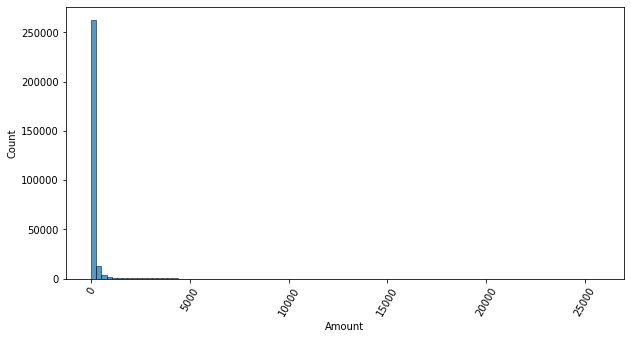

In [ ]:
plt.figure(figsize=(10,5))
plt.xticks(range(0,30000,5000),rotation=60) #adjust the scale of graph with xticks,yticks #rotation is a must
sns.histplot(fraud_df['Amount'],bins=100) #histplot for float data #adjust bin

In [ ]:
fraud_df.Amount=np.log1p(fraud_df.Amount)

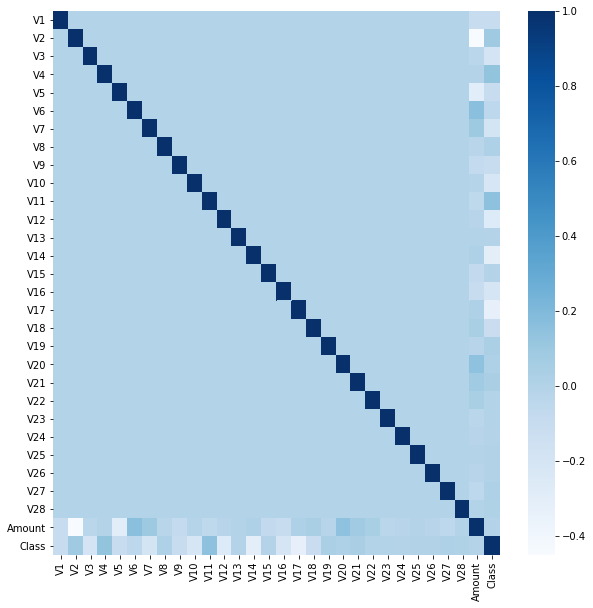

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(fraud_df.corr(),cmap='Blues') 

In [ ]:
def erase_outlier(feature):
  quantile_25=np.percentile(fraud_df[feature],25)
  quantile_75=np.percentile(fraud_df[feature],75) 
  iqr=quantile_75-quantile_25 #higher quantile, higher value
  min=quantile_25-iqr*1.5
  max=quantile_75+iqr*1.5
  fraud_df.loc[(fraud_df[feature]>min)&(fraud_df[feature]<max),feature]=fraud_df[feature].mean()

In [ ]:
erase_outlier('V14') #features that have weakest correlation with target
erase_outlier('V17')

#3.Modeling

In [ ]:
fraud_label=fraud_df['Class']
fraud_feature=fraud_df.drop(['Class'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(fraud_feature,fraud_label,test_size=0.3,random_state=0,stratify=fraud_label) 

In [ ]:
X_train,y_train=SMOTE(random_state=0).fit_sample(X_train,y_train) #only train data(test data must be true) #returns ndarray
pd.Series(y_train).value_counts()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    199020
0    199020
dtype: int64

In [ ]:
def get_eval(real,pred):
  print('Accuracy score:{0:.4f} / Recall score:{1:.4f} / Precision score:{2:.4f} / roc_auc_score:{3:.4f}'.format(accuracy_score(real,pred),recall_score(real,pred),precision_score(real,pred),roc_auc_score(real,pred)))

In [ ]:
lr_clf=LogisticRegression(random_state=0) #even with no tuning score's this high #30*300000size dataset doesn't take long
lr_clf.fit(X_train,y_train)
pred1=lr_clf.predict(X_test) 
get_eval(y_test,pred1)

Accuracy score:0.9787 / Recall score:0.8784 / Precision score:0.0673 / roc_auc_score:0.9286


In [ ]:
lgbm_clf=LGBMClassifier(learning_rate=0.02,n_estimators=1000,colsample_bytree=0.8,subsample=0.8,randomstate=0,boost_from_average=False) #only false when highly disproportionate
lgbm_clf.fit(X_train,y_train)
pred2=lgbm_clf.predict(X_test)
get_eval(y_test,pred2)

Accuracy score:0.9994 / Recall score:0.7973 / Precision score:0.8489 / roc_auc_score:0.8985


In [ ]:
vo_clf=VotingClassifier([('lr',lr_clf),('lgbm',lgbm_clf)],voting='soft')
vo_clf.fit(X_train,y_train)
pred=vo_clf.predict(X_test)
get_eval(y_test,pred)

Accuracy score:0.9988 / Recall score:0.8446 / Precision score:0.6158 / roc_auc_score:0.9218


#1)Uploading

#2)Feedback
baseline<br>
Accuracy score:0.9995 / Recall score:0.7432 / Precision score:0.9322 / roc_auc_score:0.8716<br>

log scaling<br>
Accuracy score:0.9995 / Recall score:0.7432 / Precision score:0.9402 / roc_auc_score:0.8716<br>

outlier removal : Huge improvement<br> 
Accuracy score:0.9995 / Recall score:0.7500 / Precision score:0.9407 / roc_auc_score:0.8750<br>

SMOTE : Admirable improvement+But sharp drop in Precision(too many positives produced FPs)<br>
Accuracy score:0.9988 / Recall score:0.8446 / Precision score:0.6158 / roc_auc_score:0.9218

#3)Afterwords